In [1]:
# from google.colab import files
# files.upload()  # Upload kaggAle.json manually

In [2]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
import os

os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

In [4]:
# Example
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
!unzip -o lung-and-colon-cancer-histopathological-images.zip
print('The data set has been extracted.')

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [5]:
# Install necessary libraries: OpenCV for image processing and TensorFlow for building the model
!pip install opencv-python tensorflow

# 1. Importing Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

# 2. Importing Dataset

In [7]:
# List the contents of the lung image sets directory to see the class folders
import os
print(os.listdir('./lung_colon_image_set/lung_image_sets'))

['lung_n', 'lung_aca', 'lung_scc']


In [8]:
# Define paths to image directories and list the class names by checking subdirectories
path_lung = './lung_colon_image_set/lung_image_sets'
path_colon = './lung_colon_image_set/colon_image_sets'

classes = []
# Check if lung path exists and add subdirectories as classes
if os.path.exists(path_lung):
  classes.extend([d for d in os.listdir(path_lung) if os.path.isdir(os.path.join(path_lung, d))])
# Check if colon path exists and add subdirectories as classes
if os.path.exists(path_colon):
  classes.extend([d for d in os.listdir(path_colon) if os.path.isdir(os.path.join(path_colon, d))])

print("Detected classes:", classes)

Detected classes: ['lung_n', 'lung_aca', 'lung_scc', 'colon_n', 'colon_aca']


# 3. Visualizing the Data

lung_n: 500 images loaded


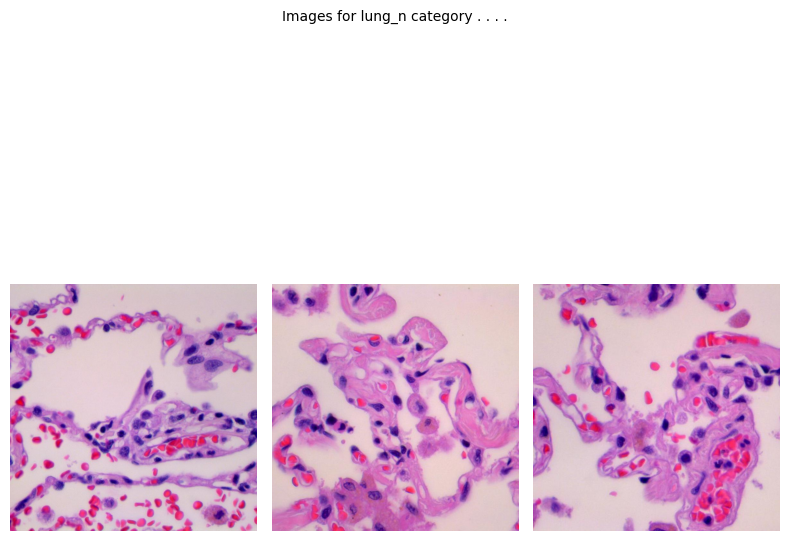

lung_aca: 500 images loaded


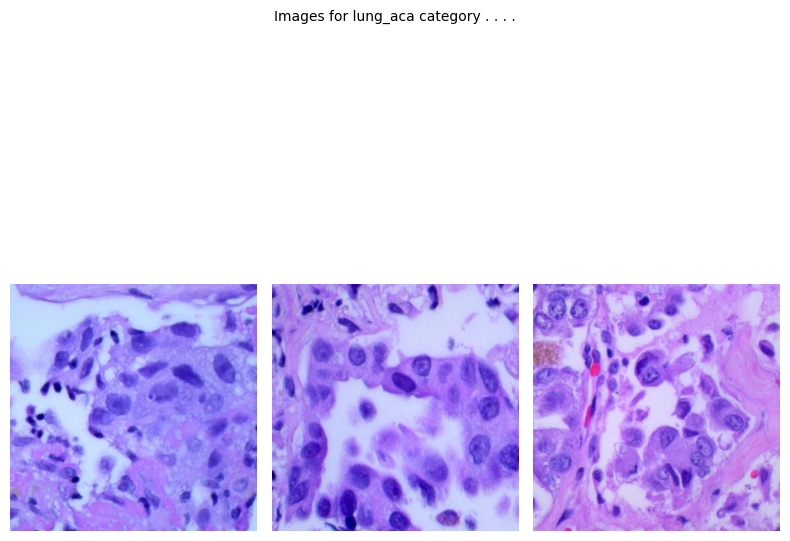

lung_scc: 500 images loaded


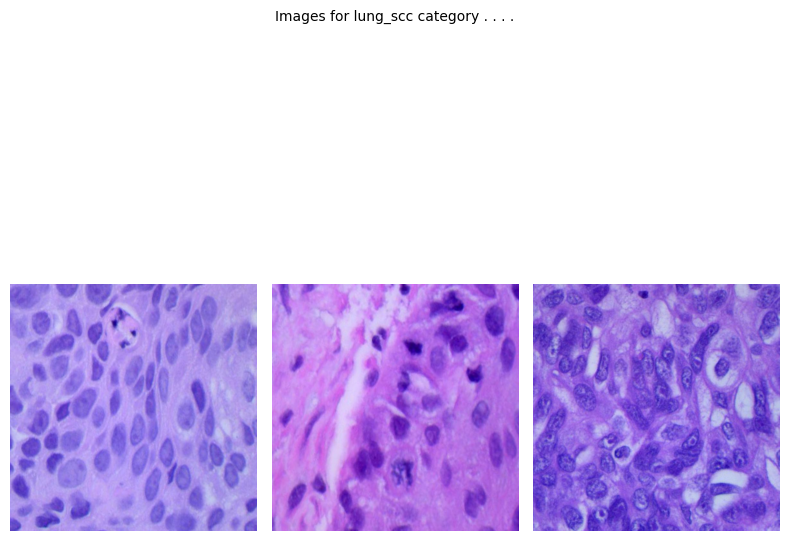

colon_n: 500 images loaded


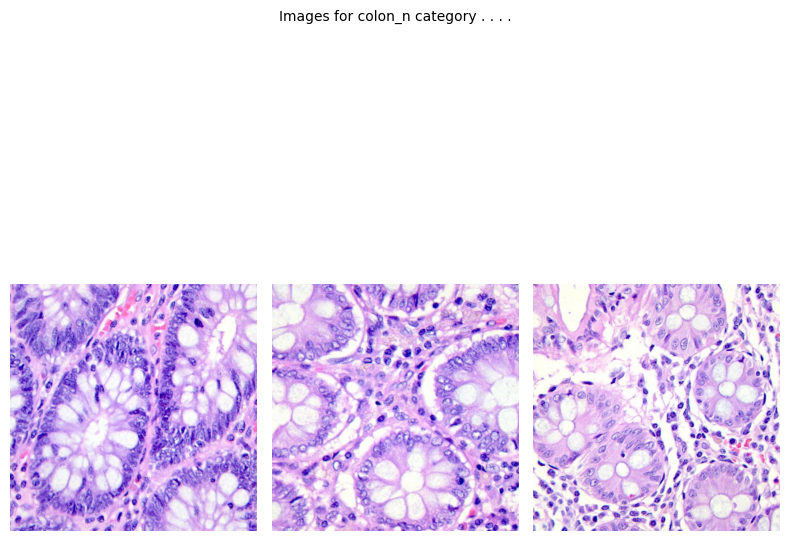

colon_aca: 500 images loaded


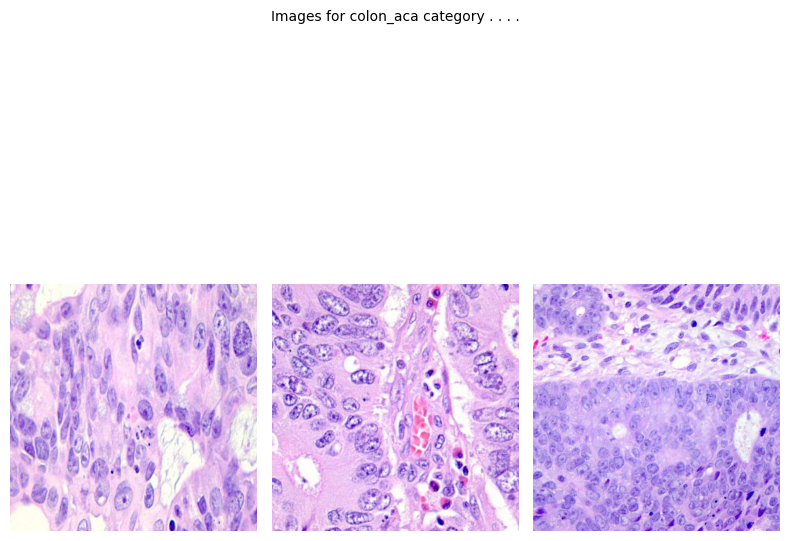


Total images loaded across all classes: 2500


In [9]:
# Iterate through each class, load a subset of images, and display examples
total_images = 0  # Initialize counter

for cat in classes:
    if cat.startswith('lung'):
        image_dir = f'./lung_colon_image_set/lung_image_sets/{cat}'
    elif cat.startswith('colon'):
        image_dir = f'./lung_colon_image_set/colon_image_sets/{cat}'
    else:
        continue  # Skip unknown categories

    if not os.path.exists(image_dir):
        print(f"Directory not found: {image_dir}")
        continue

    # Load a maximum of 500 images per class for demonstration
    images = sorted(os.listdir(image_dir))[:500]
    count = len(images)
    total_images += count  # Add to total count

    print(f"{cat}: {count} images loaded")

    # Display the first 3 images for each class
    fig, ax = plt.subplots(1, 3, figsize=(8, 8))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=10)

    for i in range(3):
        k = np.random.randint(0, count)
        img = np.array(Image.open(f'{image_dir}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()

print(f"\nTotal images loaded across all classes: {total_images}")

In [10]:
# Verify the detected classes and check if the image paths exist
print("Classes:", classes)
if not classes:
    print("The 'classes' list is empty. Please check the previous cell outputs to ensure classes are detected.")

print("\nChecking existence of image paths:")
for cat in classes:
    lung_path = os.path.join(path_lung, cat)
    colon_path = os.path.join(path_colon, cat)
    print(f"Checking lung path for {cat}: {lung_path} exists? {os.path.exists(lung_path)}")
    print(f"Checking colon path for {cat}: {colon_path} exists? {os.path.exists(colon_path)}")

Classes: ['lung_n', 'lung_aca', 'lung_scc', 'colon_n', 'colon_aca']

Checking existence of image paths:
Checking lung path for lung_n: ./lung_colon_image_set/lung_image_sets/lung_n exists? True
Checking colon path for lung_n: ./lung_colon_image_set/colon_image_sets/lung_n exists? False
Checking lung path for lung_aca: ./lung_colon_image_set/lung_image_sets/lung_aca exists? True
Checking colon path for lung_aca: ./lung_colon_image_set/colon_image_sets/lung_aca exists? False
Checking lung path for lung_scc: ./lung_colon_image_set/lung_image_sets/lung_scc exists? True
Checking colon path for lung_scc: ./lung_colon_image_set/colon_image_sets/lung_scc exists? False
Checking lung path for colon_n: ./lung_colon_image_set/lung_image_sets/colon_n exists? False
Checking colon path for colon_n: ./lung_colon_image_set/colon_image_sets/colon_n exists? True
Checking lung path for colon_aca: ./lung_colon_image_set/lung_image_sets/colon_aca exists? False
Checking colon path for colon_aca: ./lung_colon

# 4. Preparing the Dataset

In [11]:
# Define image size, split ratio, epochs, and batch size
IMG_SIZE = 128 # 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 32 # 64

X = [] # List to store image data
Y = [] # List to store image labels

# Load and resize images, and assign labels
for i, cat in enumerate(classes):
    if cat.startswith('lung'):
        image_dir = path_lung
    elif cat.startswith('colon'):
        image_dir = path_colon
    else:
        continue  # Skip unknown categories

    images = glob(f'{image_dir}/{cat}/*.jpeg') # Get list of image file paths

    for image in images:
        img = cv2.imread(image) # Read image using OpenCV
        if img is not None: # Add check for successful image loading
            X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE))) # Resize image and append to X
            Y.append(i) # Append class index to Y

X = np.asarray(X) # Convert list of images to numpy array
one_hot_encoded_Y = pd.get_dummies(Y).values # One-hot encode the labels

# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)

### ⚡️ CNN vs. MobileNetV2 Performance Summary

| Feature                        | **Custom CNN**                         | **MobileNetV2 (Pretrained)**                |
|-------------------------------|----------------------------------------|--------------------------------------------|
| **Training Time**             | Slower (builds filters from scratch)   | Faster (reuses pretrained feature extractor) |
| **Initial Accuracy**          | Lower, improves gradually              | Higher from early epochs                   |
| **Data Requirement**          | Needs more data to generalize well     | Performs well with limited data            |
| **Model Complexity**          | Moderate to high                       | Lightweight and efficient                  |
| **Overfitting Risk**          | Higher (due to full training)          | Lower (base model is frozen)               |
| **Customizability**           | Full control over architecture         | Limited—relying on existing structure      |
| **Best Use Case**             | Large dataset + experimentation        | Quick prototyping + small/mid-size datasets |

---

This table shows why MobileNetV2 is often the faster and more practical choice, especially in Colab sessions or edge environments.

# 5. Model Development

In [12]:
# Build the Convolutional Neural Network model
# Using a custom model architecture
# model = keras.models.Sequential([
#     # First Convolutional Layer
#     layers.Conv2D(filters=32,
#                   kernel_size=(5, 5),
#                   activation='relu',
#                   input_shape=(IMG_SIZE,
#                                IMG_SIZE,
#                                3),
#                   padding='same'),
#     layers.MaxPooling2D(2, 2), # Max Pooling Layer

#     # Second Convolutional Layer
#     layers.Conv2D(filters=64,
#                   kernel_size=(3, 3),
#                   activation='relu',
#                   padding='same'),
#     layers.MaxPooling2D(2, 2), # Max Pooling Layer

#     # Third Convolutional Layer
#     layers.Conv2D(filters=128,
#                   kernel_size=(3, 3),
#                   activation='relu',
#                   padding='same'),
#     layers.MaxPooling2D(2, 2), # Max Pooling Layer

#     layers.Flatten(), # Flatten the output for the fully connected layers
#     layers.Dense(256, activation='relu'), # First Dense Layer
#     layers.BatchNormalization(), # Batch Normalization
#     layers.Dense(128, activation='relu'), # Second Dense Layer
#     layers.Dropout(0.3), # Dropout for regularization
#     layers.BatchNormalization(), # Batch Normalization
#     layers.Dense(len(classes), activation='softmax') # Output layer with softmax activation for multi-class classification
# ])

# Print the model summary
# model.summary()

# ---------------------------------------------------------------------------------------------------------------

# Example of using a pre-trained model (MobileNetV2) - Uncomment to use
# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze weights initially

# Build the new model on top of the base model
model = keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to 1D
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(len(classes), activation='softmax')  # Final layer for class prediction
])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,109 (9.24 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [13]:
# Import necessary callbacks for model training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define a custom callback for early stopping based on validation accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True

# Early stopping callback to stop training when validation accuracy stops improving
es = EarlyStopping(patience=3, # Number of epochs with no improvement after which training will be stopped
                   monitor='val_accuracy', # Metric to be monitored
                   restore_best_weights=True) # Whether to restore model weights from the epoch with the best value of the monitored quantity

# Reduce learning rate when validation loss has stopped decreasing
lr = ReduceLROnPlateau(monitor='val_loss', # Metric to be monitored
                       patience=2, # Number of epochs with no improvement after which the learning rate will be reduced
                       factor=0.5, # Factor by which the learning rate will be reduced. new_lr = lr * factor
                       verbose=1) # Verbosity mode. 0 = silent, 1 = update messages.

# 6. Model Compilation

In [14]:
# Compile the model
model.compile(optimizer='adam', # Optimizer for training
              loss='categorical_crossentropy', # Loss function for multi-class classification
              metrics=['accuracy']) # Metrics to evaluate the model during training and testing

# 7. Model Training

In [15]:
# Train the model
history = model.fit(X_train, Y_train, # Training data and labels
                    validation_data = (X_val, Y_val), # Validation data and labels
                    batch_size = BATCH_SIZE, # Number of samples per gradient update
                    epochs = EPOCHS, # Number of epochs to train for
                    verbose = 1, # Display training progress
                    callbacks = [es, lr, myCallback()]) # Callbacks to use during training (EarlyStopping, ReduceLROnPlateau, custom callback)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 298s 466ms/step - accuracy: 0.7882 - loss: 0.5393 - val_accuracy: 0.8642 - val_loss: 0.3401 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 343s 500ms/step - accuracy: 0.8651 - loss: 0.3553 - val_accuracy: 0.8532 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 316s 490ms/step - accuracy: 0.8613 - loss: 0.3596 - val_accuracy: 0.8766 - val_loss: 0.3046 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 320s 487ms/step - accuracy: 0.8630 - loss: 0.3483 - val_accuracy: 0.8770 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 316s 477ms/step - accuracy: 0.8684 - loss: 0.3297 - val_accuracy: 0.8764 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 297s 476ms/step - accuracy: 0.8718 - loss: 0.3275 - val_accuracy: 0.8906 - val_loss: 0.2684 - learning_rate: 0.0010
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 323s 479ms/step - accura

In [16]:
# Save the trained model
model.save('lung_colon_classifier.h5')  # Saves as a single HDF5 file

In [17]:
# Load the saved model
# loaded_model = keras.models.load_model('lung_colon_classifier.h5')

In [18]:
# Make predictions on the validation data
Y_pred = model.predict(X_val)

# Convert predicted probabilities to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Get the true class labels from the validation data
Y_true_classes = np.argmax(Y_val, axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 384ms/step


8. Model Evaluation

In [19]:
# Print the classification report to evaluate model performance
print(metrics.classification_report(Y_true_classes, Y_pred_classes, target_names=classes))

              precision    recall  f1-score   support

      lung_n       0.98      0.95      0.97       967
    lung_aca       0.85      0.86      0.85      1019
    lung_scc       0.88      0.87      0.87      1010
     colon_n       0.88      0.95      0.92       999
   colon_aca       0.93      0.88      0.91      1005

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



# 9. Visualizing

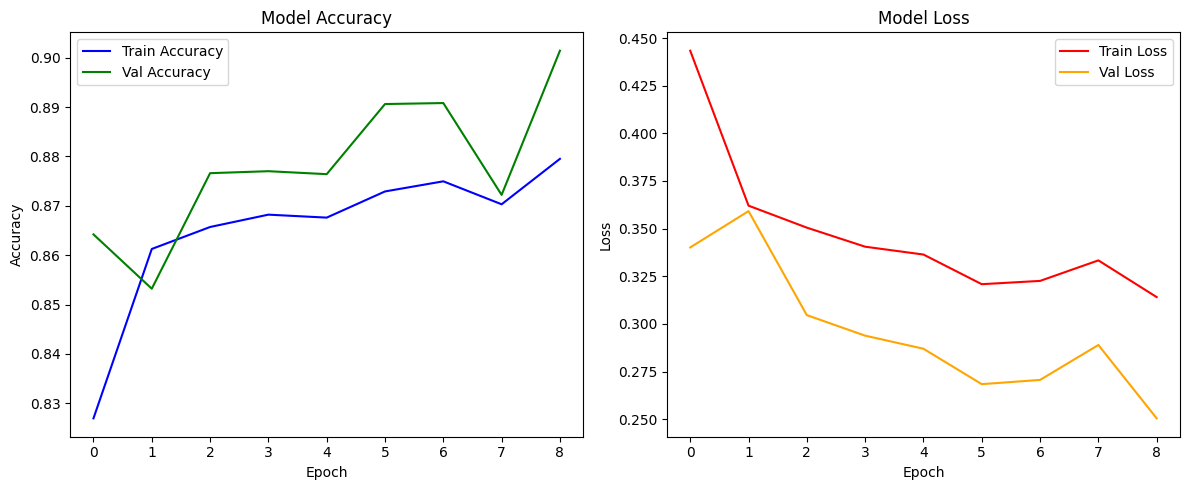

In [20]:
# Plot the training and validation accuracy and loss over epochs
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()